In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

## Q1. Downloading the data

We'll use [the same NYC taxi dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page),
but instead of "Green Taxi Trip Records", we'll use "For-Hire Vehicle Trip Records".

Download the data for January and February 2021.

Note that you need "For-Hire Vehicle Trip Records", not "High Volume For-Hire Vehicle Trip Records".

Read the data for January. How many records are there?

* 1054112
* 1154112 <- This
* 1254112
* 1354112

In [14]:
df_train = pd.read_parquet("./data/fhv_tripdata_2021-01.parquet")
df_train

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037
...,...,...,...,...,...,...,...
1154107,B03266,2021-01-31 23:43:03,2021-01-31 23:51:48,7.0,7.0,None,B03266
1154108,B03284,2021-01-31 23:50:27,2021-02-01 00:48:03,44.0,91.0,None,
1154109,B03285,2021-01-31 23:13:46,2021-01-31 23:29:58,171.0,171.0,None,B03285
1154110,B03285,2021-01-31 23:58:03,2021-02-01 00:17:29,15.0,15.0,None,B03285


## Q2. Computing duration

Now let's compute the `duration` variable. It should contain the duration of a ride in minutes. 

What's the average trip duration in January?

* 15.16
* 19.16 <- This
* 24.16
* 29.16

In [32]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.dropOff_datetime = pd.to_datetime(df.dropOff_datetime)
        df.pickup_datetime = pd.to_datetime(df.pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)
    
    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    categorical = ['PUlocationID', 'DOlocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [33]:
df_train = read_dataframe("./data/fhv_tripdata_2021-01.parquet")

In [34]:
df_train.sort_values(by="duration")

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
473482,B00221,2021-01-14 07:16:25,2021-01-14 07:16:26,nan,243.0,None,B00221,0.016667
1095574,B03147,2021-01-30 02:27:20,2021-01-30 02:27:21,92.0,92.0,None,B03147,0.016667
14967,B02657,2021-01-01 14:37:07,2021-01-01 14:37:08,nan,220.0,None,B02657,0.016667
878721,B02111,2021-01-25 04:55:29,2021-01-25 04:55:30,92.0,92.0,None,B02111,0.016667
126023,B02546,2021-01-05 08:04:15,2021-01-05 08:04:16,nan,78.0,None,B02546,0.016667
...,...,...,...,...,...,...,...,...
230325,B01985,2021-01-07 15:30:00,2021-01-17 14:04:00,nan,nan,None,B01985,14314.000000
10288,B03297,2021-01-01 10:30:00,2021-01-13 11:12:00,nan,nan,None,B03297,17322.000000
457454,B02546,2021-01-13 15:26:07,2021-01-31 17:03:15,nan,168.0,None,B02546,26017.133333
1153556,B00856,2021-01-31 23:47:00,2021-03-01 00:14:36,nan,76.0,None,B02875,40347.600000


In [35]:
list_dur = df_train.duration.values
dur_avg = sum(list_dur)/len(list_dur)
print(dur_avg)

19.1672240937939


## Data preparation

Check the distribution of the duration variable. There are some outliers. 

Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

How many records did you drop? 

In [71]:
def remove_outlier(df=df_train, col="duration", bot=1, up=60):
    df = df[(df[col] >= bot) & (df[col] <= up)]
    return df

In [38]:
df_train = remove_outlier(df_train, "duration", 1, 60)

In [40]:
drop_count = len(list_dur) - len(df_train.duration.values)
print(drop_count)

44286


## Q3. Missing values

The features we'll use for our model are the pickup and dropoff location IDs. 

But they have a lot of missing values there. Let's replace them with "-1".

What's the fractions of missing values for the pickup location ID? I.e. fraction of "-1"s after you filled the NAs.

* 53%
* 63%
* 73%
* 83% <- This

In [44]:
categorical = ["PUlocationID", "DOlocationID"]
df_train[categorical] = df_train[categorical].replace("nan", -1)

In [58]:
miss_val = (df_train[categorical] == -1).sum()
total_val = df_train[categorical].count()
rat_1, rat_2 = miss_val[0]/total_val[0] , miss_val[1]/total_val[1]
print("Missing Values for PUlocationID and DOlocationID are {} and {}",rat_1, rat_2)

Missing Values for PUlocationID and DOlocationID are {} and {} 0.8352732770722617 0.13327044059158824


## Q4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model. 

* Turn the dataframe into a list of dictionaries
* Fit a dictionary vectorizer 
* Get a feature matrix from it

What's the dimensionality of this matrix? (The number of columns).

* 2
* 152
* 352
* 525 <- This
* 725

In [60]:
train_dicts = df_train[categorical].to_dict(orient="records")

In [61]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
X_train

<1109826x525 sparse matrix of type '<class 'numpy.float64'>'
	with 2219652 stored elements in Compressed Sparse Row format>

## Q5. Training a model

Now let's use the feature matrix from the previous step to train a model. 

* Train a plain linear regression model with default parameters 
* Calculate the RMSE of the model on the training data

What's the RMSE on train?

* 5.52
* 10.52 <- This
* 15.52
* 20.52

In [62]:
target = "duration"
y_train = df_train[target].values

In [63]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

10.528519388409808

/Users/husni.zuhdi/Documents/Codes/1-Python-Workshop/mlops-zoomcamp/base/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/husni.zuhdi/Documents/Codes/1-Python-Workshop/mlops-zoomcamp/base/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


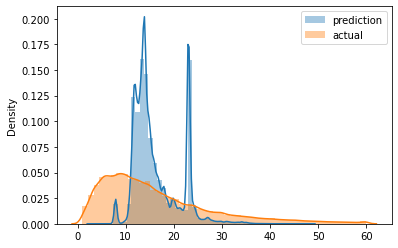

In [64]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

## Q6. Evaluating the model

Now let's apply this model to the validation dataset (Feb 2021). 

What's the RMSE on validation?

* 6.01
* 11.01
* 16.01
* 21.01

In [72]:
df_val = read_dataframe("./data/fhv_tripdata_2021-01.parquet")
df_val = remove_outlier(df_val, "duration", 1, 60)
df_val[categorical] = df_val[categorical].replace("nan", -1)

In [79]:
val_dicts = df_val[categorical].to_dict(orient="records")
X_val = dv.fit_transform(val_dicts)
y_val = df_val[target].values

In [80]:
y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

10.528519388409808